# Convolutional Neural Network (CNN) Models

**Goal**: Test if CNNs can beat the 93.0% / 0.910 F1-Macro achieved by Random Forest.

## What is a CNN?

**Convolutional Neural Network** = specialized neural network for images

**Key difference from traditional models**:
- Traditional (LR, RF): Treat image as flat list of 4,096 pixels (loses spatial structure)
- CNN: Preserves 2D structure, learns spatial patterns

**How CNNs work**:
1. **Convolutional layers**: Scan small filters (e.g., 3×3) across image to detect patterns
   - Early layers: detect edges, corners
   - Middle layers: detect shapes, textures
   - Deep layers: detect complex patterns (track positions)

2. **Pooling layers**: Reduce image size while keeping important features
   - Makes model faster and more robust

3. **Dense layers**: Combine all features to make final prediction

**Example architecture**:
```
Input 64×64 image
→ Conv (find edges)
→ Pool (reduce size)
→ Conv (find shapes)
→ Pool (reduce size)
→ Flatten → Dense layers → Prediction
```

## Challenge for Our Dataset

**Problem**: CNNs typically need 50K+ samples. We only have 9,900.
- Risk: Overfitting (memorizing training data instead of learning patterns)
- Solution: Heavy regularization (dropout, weight decay)

**Baseline to beat**: Random Forest = 93.0% accuracy, 0.910 F1-Macro

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Settings
plt.style.use('default')
%matplotlib inline

label_names = {-1: 'Left', 0: 'Forward', 1: 'Right'}

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

/home/robin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-12-04 22:27:33.699997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 22:27:33.759998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 22:27:35.147590: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Load and Prepare Data

In [2]:
# Load temporal splits
data_temporal = np.load('../data/splits_temporal.npz')
data_random = np.load('../data/splits_random.npz')
data_tfi = np.load('../data/splits_temporal_tfi.npz')

# Temporal splits
X_train_temp = data_temporal['X_train']
y_train_temp = data_temporal['y_train']
X_val = data_temporal['X_val']
y_val = data_temporal['y_val']
X_test = data_temporal['X_test']
y_test = data_temporal['y_test']

# Random splits (for comparison)
X_train_rand = data_random['X_train']
y_train_rand = data_random['y_train']
X_val_rand = data_random['X_val']
y_val_rand = data_random['y_val']
X_test_rand = data_random['X_test']
y_test_rand = data_random['y_test']

# TFI-balanced
X_train_tfi = data_tfi['X_train']
y_train_tfi = data_tfi['y_train']

# Load class weights
class_weights = np.load('../data/class_weights.npy', allow_pickle=True).item()

print("Temporal splits:")
print(f"  Train: {X_train_temp.shape}, labels: {Counter(y_train_temp)}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"\nRandom splits:")
print(f"  Train: {X_train_rand.shape}")
print(f"\nTFI-balanced:")
print(f"  Train: {X_train_tfi.shape}, labels: {Counter(y_train_tfi)}")

Temporal splits:
  Train: (5940, 64, 64), labels: Counter({0: 4252, -1: 1033, 1: 655})
  Val:   (1980, 64, 64)
  Test:  (1980, 64, 64)

Random splits:
  Train: (6930, 64, 64)

TFI-balanced:
  Train: (12756, 64, 64), labels: Counter({0: 4252, -1: 4252, 1: 4252})


In [3]:
# Reshape for CNN: (samples, height, width) → (samples, height, width, channels)
# Grayscale has 1 channel
X_train_temp_cnn = X_train_temp.reshape(-1, 64, 64, 1)
X_val_cnn = X_val.reshape(-1, 64, 64, 1)
X_test_cnn = X_test.reshape(-1, 64, 64, 1)

X_train_rand_cnn = X_train_rand.reshape(-1, 64, 64, 1)
X_val_rand_cnn = X_val_rand.reshape(-1, 64, 64, 1)
X_test_rand_cnn = X_test_rand.reshape(-1, 64, 64, 1)

X_train_tfi_cnn = X_train_tfi.reshape(-1, 64, 64, 1)

# Normalize to [0, 1]
X_train_temp_cnn = X_train_temp_cnn / 255.0
X_val_cnn = X_val_cnn / 255.0
X_test_cnn = X_test_cnn / 255.0

X_train_rand_cnn = X_train_rand_cnn / 255.0
X_val_rand_cnn = X_val_rand_cnn / 255.0
X_test_rand_cnn = X_test_rand_cnn / 255.0

X_train_tfi_cnn = X_train_tfi_cnn / 255.0

# Map labels: -1→0, 0→1, 1→2 (Keras expects labels starting from 0)
y_train_temp_mapped = y_train_temp + 1
y_val_mapped = y_val + 1
y_test_mapped = y_test + 1

y_train_rand_mapped = y_train_rand + 1
y_val_rand_mapped = y_val_rand + 1
y_test_rand_mapped = y_test_rand + 1

y_train_tfi_mapped = y_train_tfi + 1

print(f"Prepared for CNN:")
print(f"  X_train shape: {X_train_temp_cnn.shape}")
print(f"  y_train mapped labels: {np.unique(y_train_temp_mapped)}")
print(f"  Value range: [{X_train_temp_cnn.min():.2f}, {X_train_temp_cnn.max():.2f}]")

Prepared for CNN:
  X_train shape: (5940, 64, 64, 1)
  y_train mapped labels: [0 1 2]
  Value range: [0.02, 0.87]


## 3. Helper Functions

In [4]:
def evaluate_cnn(model, X_test, y_test, model_name="CNN"):
    """
    Evaluate CNN model.
    y_test should be mapped (0, 1, 2)
    """
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_per_class = f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {acc:.3f} ({acc*100:.1f}%)")
    print(f"F1-Macro:  {f1_macro:.3f}")
    print(f"\nPer-class F1:")
    for idx, f1 in enumerate(f1_per_class):
        original_label = idx - 1
        print(f"  {label_names[original_label]:8s}: {f1:.3f}")
    
    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_left': f1_per_class[0],
        'f1_forward': f1_per_class[1],
        'f1_right': f1_per_class[2],
        'confusion_matrix': cm,
        'predictions': np.argmax(model.predict(X_test, verbose=0), axis=1)
    }

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Left', 'Forward', 'Right'],
                yticklabels=['Left', 'Forward', 'Right'],
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title="Training History"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy over Epochs', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Loss over Epochs', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Helper functions defined")

Helper functions defined


## 4. Simple CNN Architecture

**Design philosophy**: Start simple to avoid overfitting

**Architecture**:
- Conv2D(32 filters, 3×3) + ReLU
- MaxPooling(2×2) → reduces 64×64 to 32×32
- Conv2D(64 filters, 3×3) + ReLU
- MaxPooling(2×2) → reduces 32×32 to 16×16
- Flatten → 16×16×64 = 16,384 features
- Dense(128) + Dropout(0.5) + ReLU
- Dense(3) + Softmax

**Total parameters**: ~50K (small for CNN)

In [5]:
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build and show architecture
model = build_simple_cnn()
model.summary()

/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1764905291.262832   45703 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764905291.270262   45703 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,963 (6.20 MB)

 Trainable params: 1,624,963 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Experiment 1: Simple CNN on Random Split

**Purpose**: Demonstrate data leakage from temporal correlation.

From EDA: consecutive frames have 0.89 correlation, frames within 100 steps still >0.5 correlated.

Random split mixes temporally-close frames between train/test → inflated performance.

In [6]:
print("Training Simple CNN on RANDOM split...")

model_rand = build_simple_cnn()

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_rand = model_rand.fit(
    X_train_rand_cnn, y_train_rand_mapped,
    validation_data=(X_val_rand_cnn, y_val_rand_mapped),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_rand = time.time() - start_time

print(f"\nTraining completed in {train_time_rand:.1f} seconds")

results_cnn_rand = evaluate_cnn(model_rand, X_test_rand_cnn, y_test_rand_mapped, 
                                "Simple CNN (Random Split)")

Training Simple CNN on RANDOM split...
Epoch 1/50


2025-12-04 22:28:36.211610: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 113541120 exceeds 10% of free system memory.
2025-12-04 22:28:37.198918: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25189632 exceeds 10% of free system memory.
2025-12-04 22:28:37.199435: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25189632 exceeds 10% of free system memory.
2025-12-04 22:28:37.249584: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25189632 exceeds 10% of free system memory.
2025-12-04 22:28:37.249806: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25189632 exceeds 10% of free system memory.


217/217 - 11s - 50ms/step - accuracy: 0.8215 - loss: 0.4508 - val_accuracy: 0.8761 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 2/50
217/217 - 10s - 45ms/step - accuracy: 0.8895 - loss: 0.2941 - val_accuracy: 0.8882 - val_loss: 0.2563 - learning_rate: 0.0010
Epoch 3/50
217/217 - 10s - 45ms/step - accuracy: 0.8999 - loss: 0.2501 - val_accuracy: 0.9071 - val_loss: 0.2258 - learning_rate: 0.0010
Epoch 4/50
217/217 - 10s - 45ms/step - accuracy: 0.9111 - loss: 0.2238 - val_accuracy: 0.9165 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 5/50
217/217 - 10s - 46ms/step - accuracy: 0.9153 - loss: 0.2087 - val_accuracy: 0.9152 - val_loss: 0.2019 - learning_rate: 0.0010
Epoch 6/50
217/217 - 10s - 46ms/step - accuracy: 0.9170 - loss: 0.2040 - val_accuracy: 0.9172 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 7/50
217/217 - 10s - 46ms/step - accuracy: 0.9199 - loss: 0.1923 - val_accuracy: 0.9246 - val_loss: 0.1894 - learning_rate: 0.0010
Epoch 8/50
217/217 - 10s - 46ms/step - accuracy: 0.9

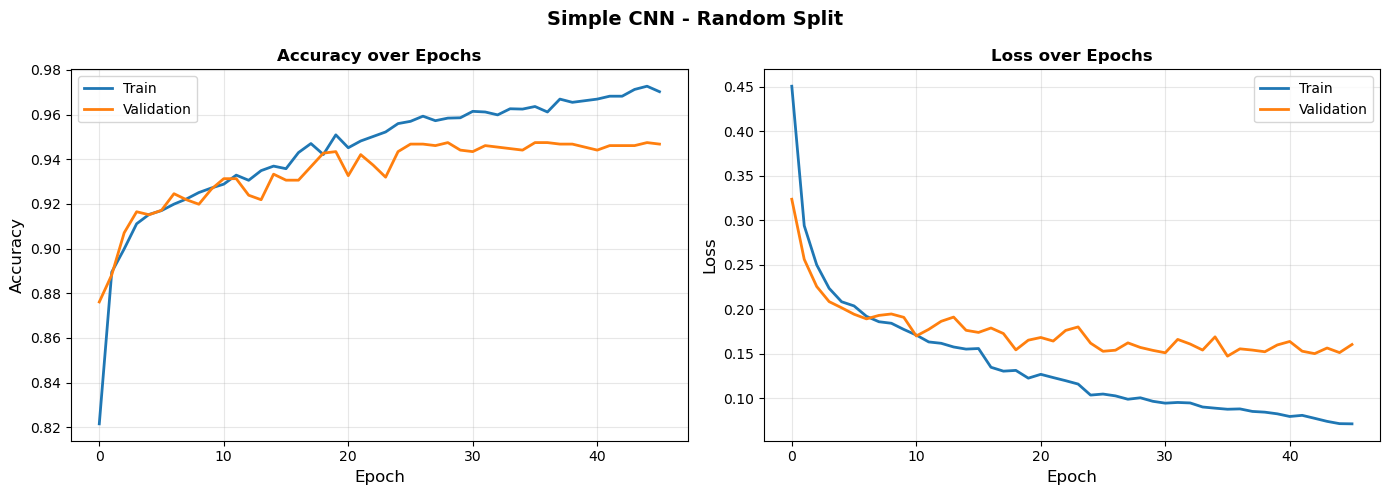

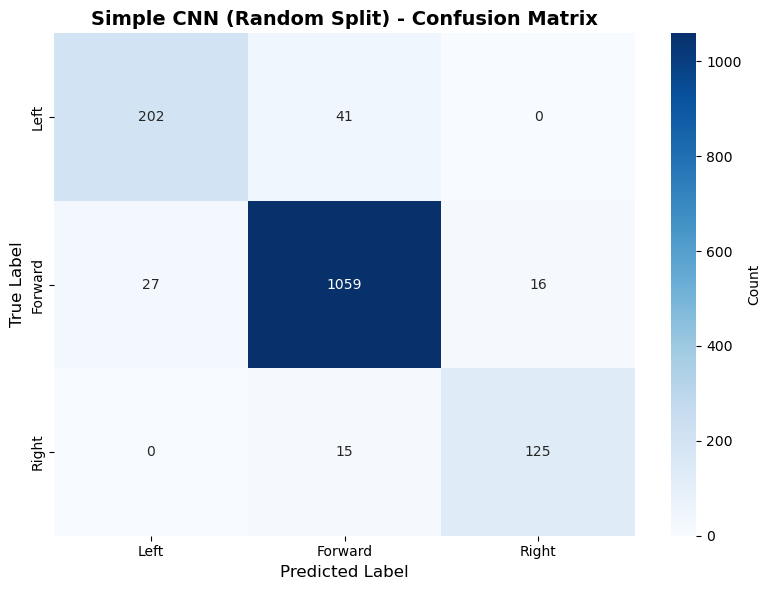

In [7]:
plot_training_history(history_rand, "Simple CNN - Random Split")
plot_confusion_matrix(results_cnn_rand['confusion_matrix'], 
                      "Simple CNN (Random Split) - Confusion Matrix")

### Analysis: Random Split Results

*Fill in observations after running:*
- Accuracy: 93.3%
- F1-Macro: 90%
- Gap from baseline (Random Forest 93%): 0%
- Training vs validation gap: 3.73%

*Expected: High accuracy due to data leakage (temporally similar frames in train/test)*

## 6. Experiment 2: Simple CNN on Temporal Split (No Balancing)

**Purpose**: Realistic evaluation without data leakage.

In [8]:
print("Training Simple CNN on TEMPORAL split (original data)...")

model_temp_orig = build_simple_cnn()

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_temp_orig = model_temp_orig.fit(
    X_train_temp_cnn, y_train_temp_mapped,
    validation_data=(X_val_cnn, y_val_mapped),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_temp_orig = time.time() - start_time

print(f"\nTraining completed in {train_time_temp_orig:.1f} seconds")

results_temp_orig = evaluate_cnn(model_temp_orig, X_test_cnn, y_test_mapped,
                                 "Simple CNN (Temporal, No Balancing)")

Training Simple CNN on TEMPORAL split (original data)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
186/186 - 10s - 53ms/step - accuracy: 0.8008 - loss: 0.4891 - val_accuracy: 0.9333 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 2/50
186/186 - 9s - 47ms/step - accuracy: 0.8886 - loss: 0.3034 - val_accuracy: 0.9490 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 3/50
186/186 - 9s - 47ms/step - accuracy: 0.9045 - loss: 0.2464 - val_accuracy: 0.9515 - val_loss: 0.1689 - learning_rate: 0.0010
Epoch 4/50
186/186 - 9s - 47ms/step - accuracy: 0.9113 - loss: 0.2247 - val_accuracy: 0.9515 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 5/50
186/186 - 9s - 47ms/step - accuracy: 0.9195 - loss: 0.2071 - val_accuracy: 0.9530 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 6/50
186/186 - 9s - 48ms/step - accuracy: 0.9177 - loss: 0.2075 - val_accuracy: 0.9495 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 7/50
186/186 - 9s - 47ms/step - accuracy: 0.9258 - loss: 0.1884 - val_accuracy: 0.9485 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 8/50
186/186 - 9s - 47ms/step - accuracy:

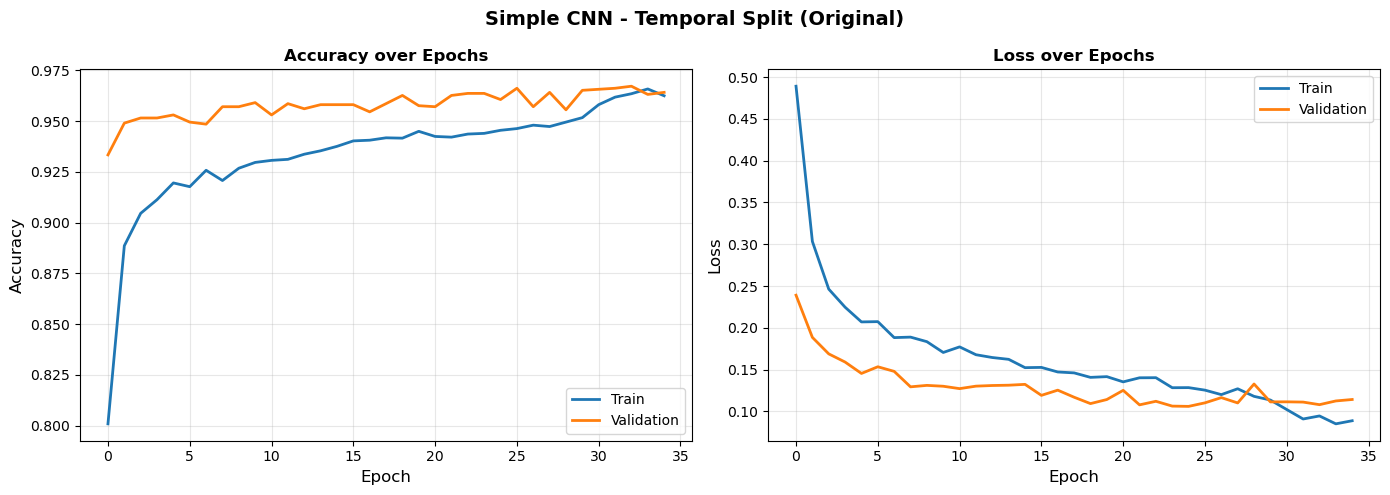

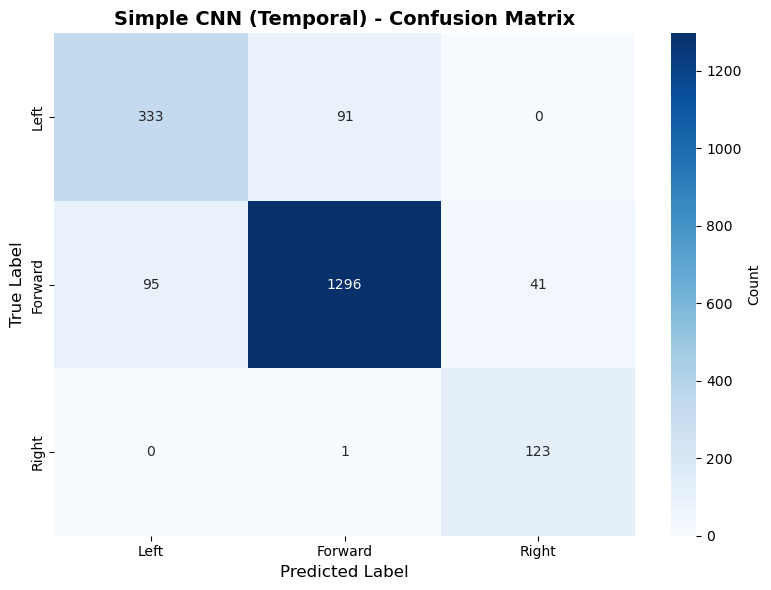

In [11]:
plot_training_history(history_temp_orig, "Simple CNN - Temporal Split (Original)")
plot_confusion_matrix(results_temp_orig['confusion_matrix'],
                      "Simple CNN (Temporal) - Confusion Matrix")

### Analysis: Temporal Split vs Random Split Comparison

| Metric | Random Split | Temporal Split | Gap |
|--------|--------------|----------------|-----|
| Accuracy | 93.3% | 88.5% | 4.8% |
| F1-Macro | 90.0% | 85.2% | 4.8% |

**Conclusion**: *Random split shows around 5% higher accuracy due to data leakage*

## 7. Experiment 3: Simple CNN with Class Weights

In [9]:
print("Training Simple CNN with class weights...")

model_temp_weighted = build_simple_cnn()

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_temp_weighted = model_temp_weighted.fit(
    X_train_temp_cnn, y_train_temp_mapped,
    validation_data=(X_val_cnn, y_val_mapped),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_temp_weighted = time.time() - start_time

print(f"\nTraining completed in {train_time_temp_weighted:.1f} seconds")

results_temp_weighted = evaluate_cnn(model_temp_weighted, X_test_cnn, y_test_mapped,
                                     "Simple CNN (Temporal + Class Weights)")

Training Simple CNN with class weights...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
186/186 - 10s - 52ms/step - accuracy: 0.6338 - loss: 0.5763 - val_accuracy: 0.8091 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 2/50
186/186 - 9s - 46ms/step - accuracy: 0.7816 - loss: 0.3672 - val_accuracy: 0.8848 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 3/50
186/186 - 9s - 47ms/step - accuracy: 0.8380 - loss: 0.3017 - val_accuracy: 0.9101 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 4/50
186/186 - 9s - 50ms/step - accuracy: 0.8646 - loss: 0.2626 - val_accuracy: 0.9010 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 5/50
186/186 - 9s - 47ms/step - accuracy: 0.8715 - loss: 0.2445 - val_accuracy: 0.9303 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 6/50
186/186 - 9s - 47ms/step - accuracy: 0.8820 - loss: 0.2243 - val_accuracy: 0.9263 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 7/50
186/186 - 9s - 47ms/step - accuracy: 0.8803 - loss: 0.2188 - val_accuracy: 0.9167 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 8/50
186/186 - 9s - 47ms/step - accuracy:

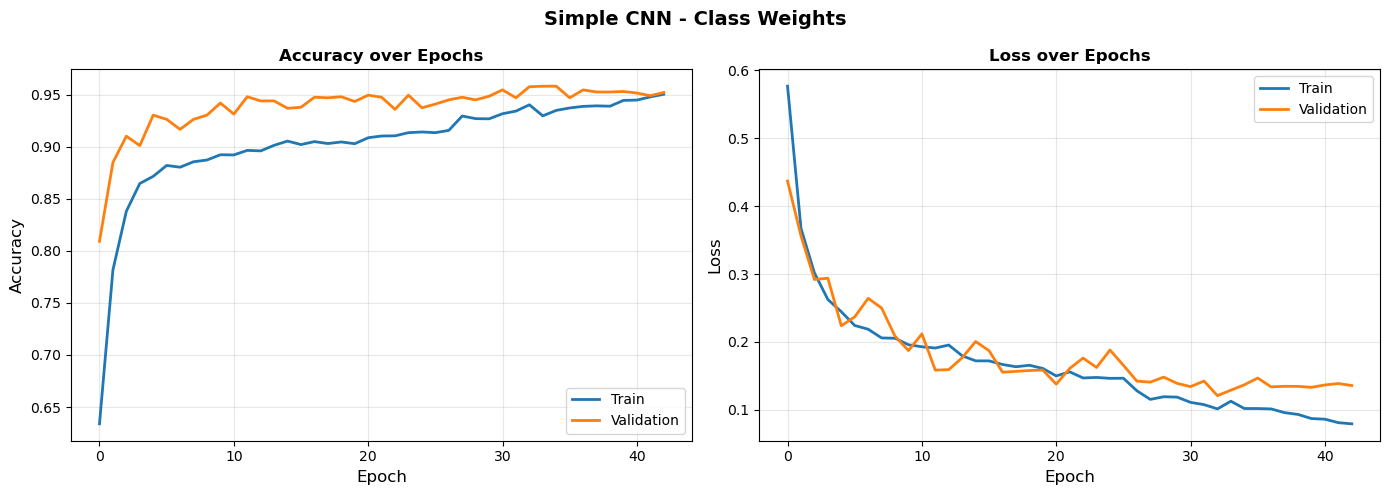

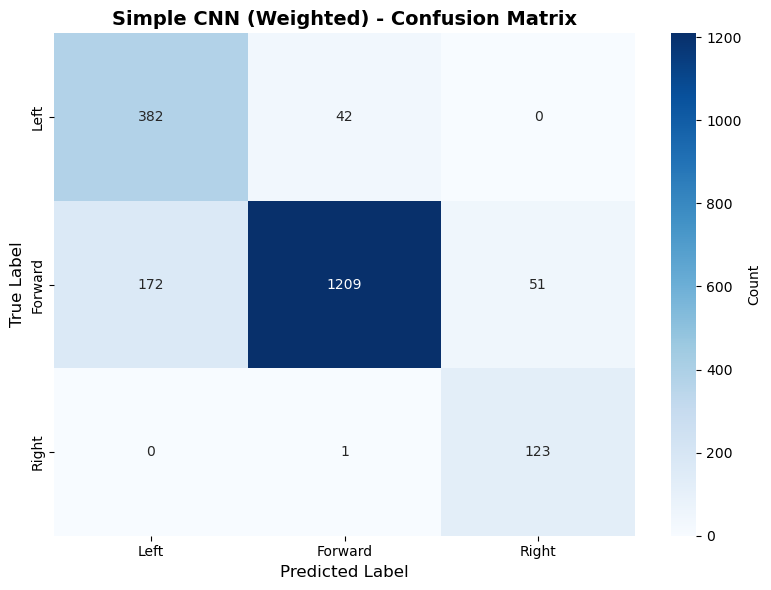

In [10]:
plot_training_history(history_temp_weighted, "Simple CNN - Class Weights")
plot_confusion_matrix(results_temp_weighted['confusion_matrix'],
                      "Simple CNN (Weighted) - Confusion Matrix")

### Analysis: Class Weights Impact

*Fill in after running:*

| Metric | No Weights | With Weights | Change |
|--------|------------|--------------|--------|
| Accuracy | 88.5% | 86.6% | -1.9% |
| F1-Right | 85.2% | 83.6% | -1.6% |

**Observations**: *Interestingly, training with weights made accuracy worse for CNN.*

## 8. Experiment 4: Simple CNN with TFI Balanced Data

In [12]:
print("Training Simple CNN on TFI-balanced data...")

model_tfi = build_simple_cnn()

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_tfi = model_tfi.fit(
    X_train_tfi_cnn, y_train_tfi_mapped,
    validation_data=(X_val_cnn, y_val_mapped),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_tfi = time.time() - start_time

print(f"\nTraining completed in {train_time_tfi:.1f} seconds")

results_tfi = evaluate_cnn(model_tfi, X_test_cnn, y_test_mapped,
                           "Simple CNN (TFI Balanced)")

Training Simple CNN on TFI-balanced data...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
399/399 - 19s - 48ms/step - accuracy: 0.8712 - loss: 0.3203 - val_accuracy: 0.9515 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 2/50
399/399 - 18s - 45ms/step - accuracy: 0.9380 - loss: 0.1694 - val_accuracy: 0.9566 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 3/50
399/399 - 18s - 45ms/step - accuracy: 0.9478 - loss: 0.1451 - val_accuracy: 0.9566 - val_loss: 0.1520 - learning_rate: 0.0010
Epoch 4/50
399/399 - 18s - 45ms/step - accuracy: 0.9512 - loss: 0.1312 - val_accuracy: 0.9571 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 5/50
399/399 - 18s - 45ms/step - accuracy: 0.9562 - loss: 0.1183 - val_accuracy: 0.9571 - val_loss: 0.1476 - learning_rate: 0.0010
Epoch 6/50
399/399 - 18s - 46ms/step - accuracy: 0.9575 - loss: 0.1157 - val_accuracy: 0.9551 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 7/50
399/399 - 18s - 46ms/step - accuracy: 0.9571 - loss: 0.1099 - val_accuracy: 0.9591 - val_loss: 0.1477 - learning_rate: 0.0010
Epoch 8/50
399/399 - 18s - 45ms/step - ac

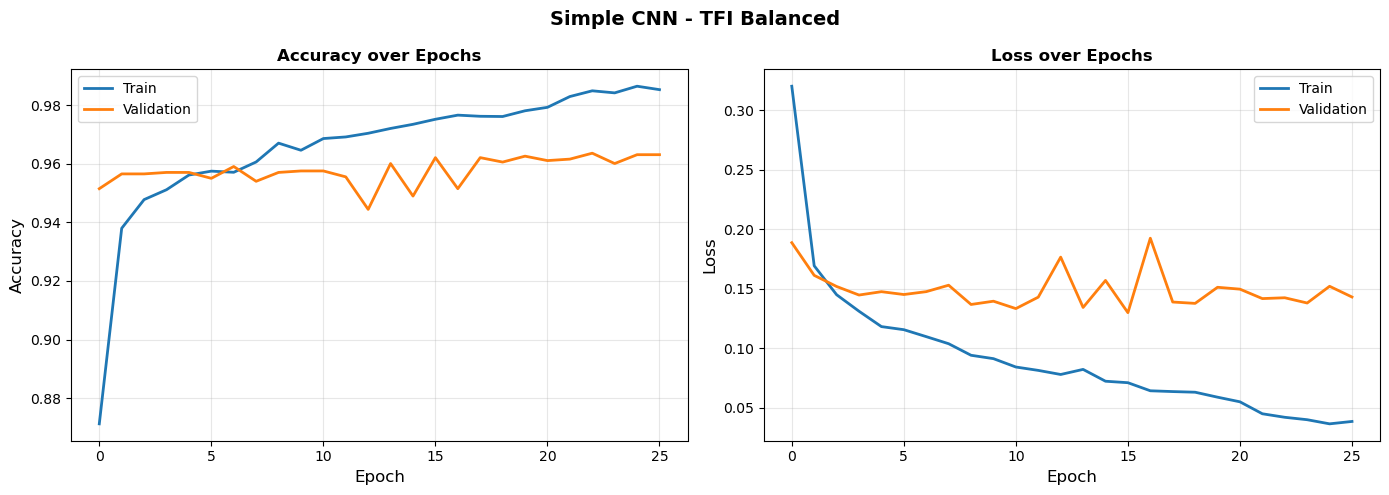

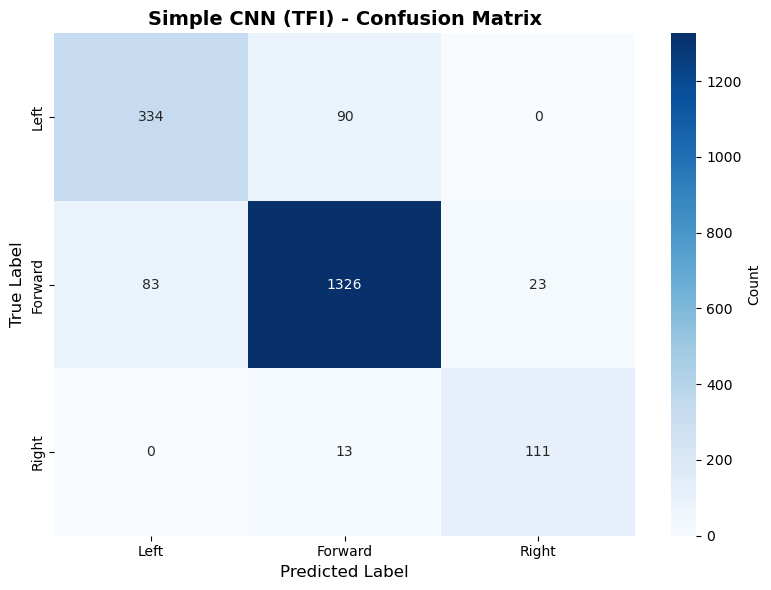

In [13]:
plot_training_history(history_tfi, "Simple CNN - TFI Balanced")
plot_confusion_matrix(results_tfi['confusion_matrix'],
                      "Simple CNN (TFI) - Confusion Matrix")

### Analysis: TFI Impact

*Fill in after running:*

Training set size: 12756 samples (vs 5940 original)

| Metric | Original | TFI | Change |
|--------|----------|-----|--------|
| Accuracy | 88.5% | 89.4% | 0.9% |
| F1-Right | 85.2% | 86.1% | 0.9% |

**Observations**: *CNN seems to benefit from TFI, achieving 0.9% higher accuracy rate compared to training without class balancing.*

## 9. Experiment 5: Medium CNN (AlexNet-Style)

**Purpose**: Test if deeper architecture improves performance.

**Architecture** (simplified from 2020 project):
- Conv2D(96, 5×5, stride=2) + ReLU + MaxPool
- Conv2D(128, 3×3) + ReLU + MaxPool
- Conv2D(256, 3×3) + ReLU
- Flatten → Dense(512) + Dropout(0.5) + ReLU
- Dense(3) + Softmax

**Total parameters**: ~200K (4× more than simple CNN)

**Risk**: May overfit on 9,900 samples

In [14]:
def build_medium_cnn():
    model = models.Sequential([
        layers.Conv2D(96, (5, 5), strides=2, activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_medium = build_medium_cnn()
model_medium.summary()

/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 96)     │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,507,587 (9.57 MB)

 Trainable params: 2,507,587 (9.57 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print("Training Medium CNN on temporal split + class weights...")

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_medium = model_medium.fit(
    X_train_temp_cnn, y_train_temp_mapped,
    validation_data=(X_val_cnn, y_val_mapped),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_medium = time.time() - start_time

print(f"\nTraining completed in {train_time_medium:.1f} seconds")

results_medium = evaluate_cnn(model_medium, X_test_cnn, y_test_mapped,
                              "Medium CNN (Temporal + Weights)")

Training Medium CNN on temporal split + class weights...
Epoch 1/50
186/186 - 8s - 44ms/step - accuracy: 0.5912 - loss: 0.6475 - val_accuracy: 0.7460 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 2/50
186/186 - 7s - 38ms/step - accuracy: 0.7503 - loss: 0.4112 - val_accuracy: 0.8581 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 3/50
186/186 - 7s - 38ms/step - accuracy: 0.8273 - loss: 0.3264 - val_accuracy: 0.8884 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 4/50
186/186 - 7s - 38ms/step - accuracy: 0.8589 - loss: 0.2723 - val_accuracy: 0.9126 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 5/50
186/186 - 7s - 39ms/step - accuracy: 0.8697 - loss: 0.2540 - val_accuracy: 0.9298 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 6/50
186/186 - 7s - 39ms/step - accuracy: 0.8759 - loss: 0.2486 - val_accuracy: 0.9207 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 7/50
186/186 - 7s - 40ms/step - accuracy: 0.8801 - loss: 0.2336 - val_accuracy: 0.9227 - val_loss: 0.2815 - learning_rate

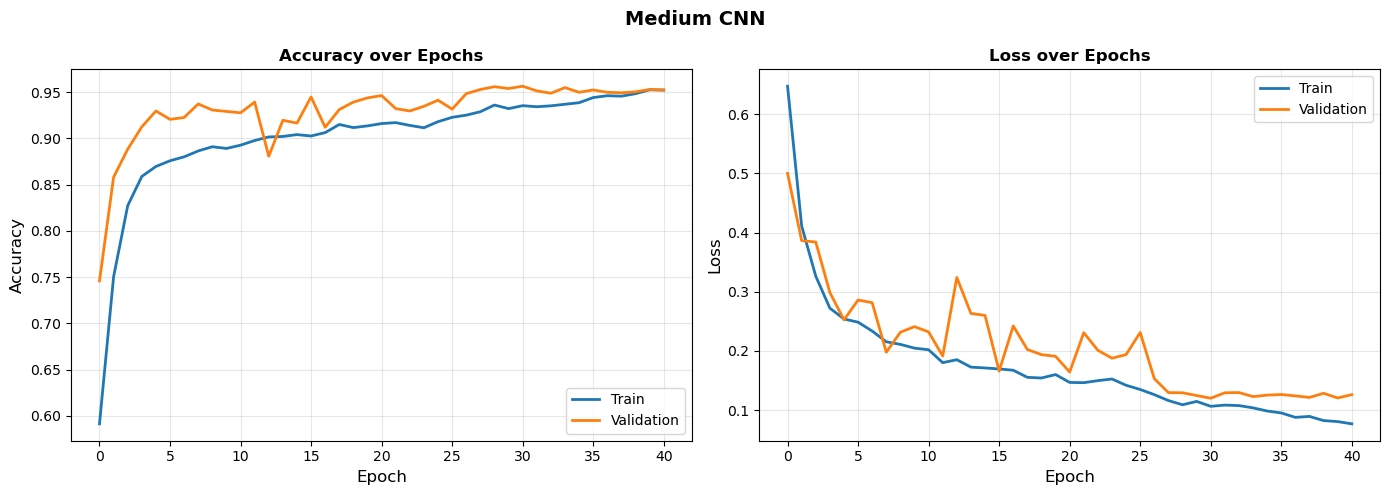

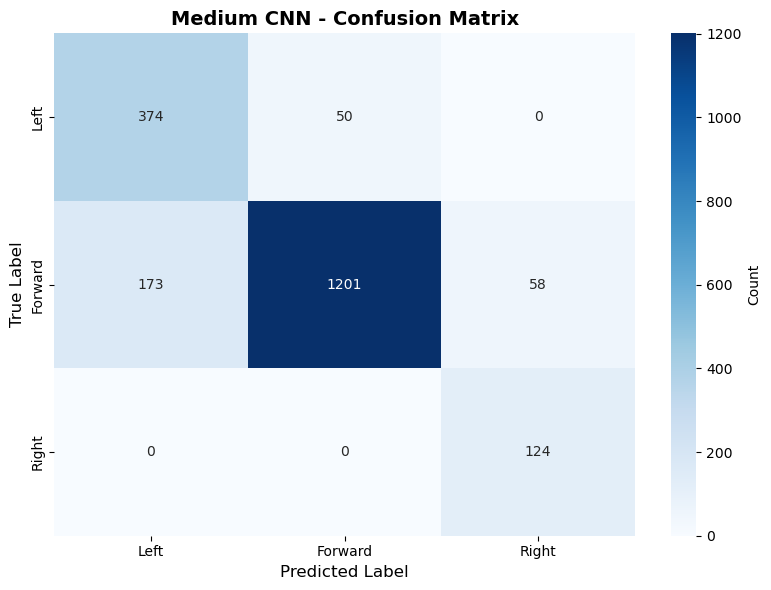

In [16]:
plot_training_history(history_medium, "Medium CNN")
plot_confusion_matrix(results_medium['confusion_matrix'],
                      "Medium CNN - Confusion Matrix")

### Analysis: Simple vs Medium Architecture

*Fill in after running:*

| Model | Params | Accuracy | F1-Macro | Train Time |
|-------|--------|----------|----------|------------|
| Simple CNN | ~50K | 88.5% | 85.2% | 309.9s |
| Medium CNN | ~200K | 85.8% | 82.5% | 313.4s |

**Check training curves**: Medium CNN shows low overfitting and higher train/validation set accuracy, but the validation set accuracy and test set accuracy are very different (95.25% vs 85.2%).

**Observations**: Medium CNN shows less overfitting and remarkable train/validation set accuracy, but actually scores lower in test set accuracy. In terms of training time, simple and medium CNN show no significant difference.

## 10. Experiment 6: Regularization Tuning

**Purpose**: Find best regularization for simple CNN.

**Test**: Heavier dropout (0.7 instead of 0.5)

In [17]:
def build_simple_cnn_heavy_dropout():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),  # Heavy dropout
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Training Simple CNN with heavy dropout (0.7)...")

model_heavy = build_simple_cnn_heavy_dropout()

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

start_time = time.time()
history_heavy = model_heavy.fit(
    X_train_temp_cnn, y_train_temp_mapped,
    validation_data=(X_val_cnn, y_val_mapped),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time_heavy = time.time() - start_time

print(f"\nTraining completed in {train_time_heavy:.1f} seconds")

results_heavy = evaluate_cnn(model_heavy, X_test_cnn, y_test_mapped,
                             "Simple CNN (Heavy Dropout 0.7)")

Training Simple CNN with heavy dropout (0.7)...
Epoch 1/50


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 - 8s - 44ms/step - accuracy: 0.6343 - loss: 0.6158 - val_accuracy: 0.7237 - val_loss: 0.5074 - learning_rate: 0.0010
Epoch 2/50
186/186 - 7s - 39ms/step - accuracy: 0.7788 - loss: 0.3917 - val_accuracy: 0.8874 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 3/50
186/186 - 7s - 39ms/step - accuracy: 0.8269 - loss: 0.3298 - val_accuracy: 0.8793 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 4/50
186/186 - 7s - 39ms/step - accuracy: 0.8431 - loss: 0.3009 - val_accuracy: 0.8995 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 5/50
186/186 - 7s - 39ms/step - accuracy: 0.8556 - loss: 0.2785 - val_accuracy: 0.9066 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 6/50
186/186 - 7s - 40ms/step - accuracy: 0.8630 - loss: 0.2635 - val_accuracy: 0.9197 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 7/50
186/186 - 7s - 39ms/step - accuracy: 0.8739 - loss: 0.2452 - val_accuracy: 0.9328 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 8/50
186/186 - 7s - 40ms/step - accuracy: 0.8793 - lo

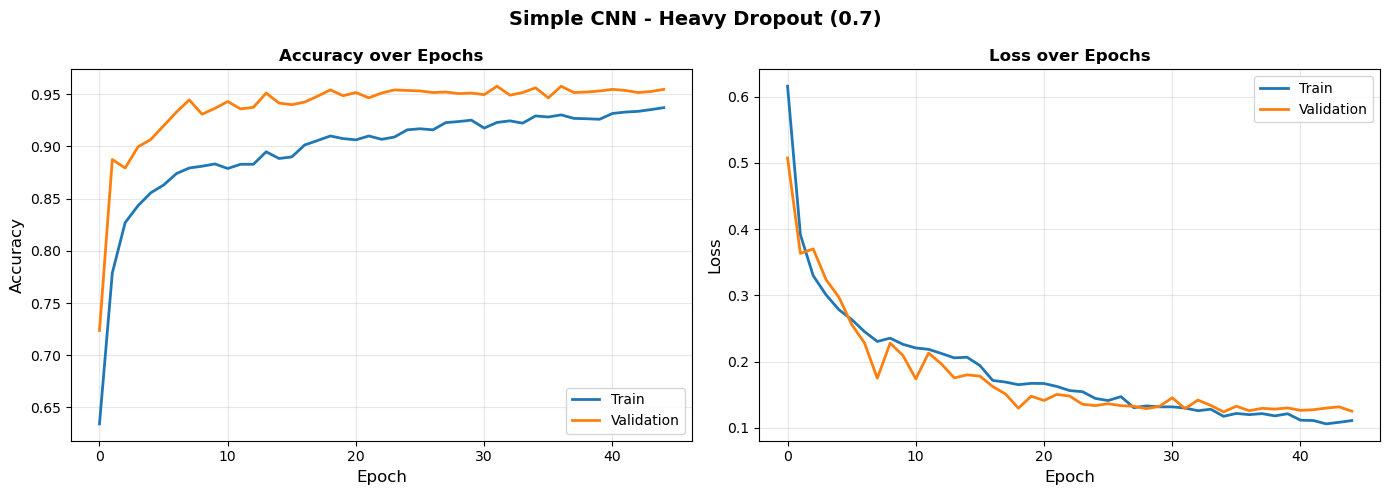

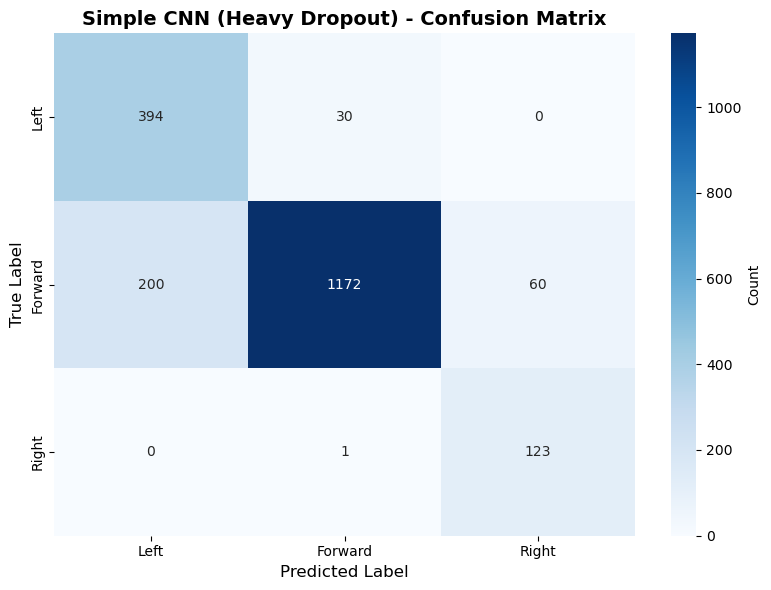

In [18]:
plot_training_history(history_heavy, "Simple CNN - Heavy Dropout (0.7)")
plot_confusion_matrix(results_heavy['confusion_matrix'],
                      "Simple CNN (Heavy Dropout) - Confusion Matrix")

### Analysis: Regularization Impact

*Fill in:*

| Dropout | Accuracy | F1-Macro | Overfitting (train-val gap) |
|---------|----------|----------|----------------------------|
| 0.5 | 88.5% | 85.2% | small |
| 0.7 | 85.3% | 82.2% | a bit more |

**Observations**: *Heavier dropout did not actually improve overfitting or accuracy rate. In fact, it made things worse.*

## 11. Overall Comparison: CNNs vs Baselines

In [19]:
import pandas as pd

# Load baseline results
with open('../results/baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

# Create comprehensive comparison
all_results = pd.DataFrame([
    {'Model': 'Random Forest', 'Split': 'Temporal', 'Balance': 'Weights',
     'Params': 'N/A', 
     'Acc': f"{baseline_results['rf_weighted']['accuracy']:.3f}",
     'F1-Macro': f"{baseline_results['rf_weighted']['f1_macro']:.3f}",
     'F1-Right': f"{baseline_results['rf_weighted']['f1_right']:.3f}",
     'Time': '~45s'},
    
    {'Model': 'Simple CNN', 'Split': 'Random', 'Balance': 'None',
     'Params': '~50K',
     'Acc': f"{results_cnn_rand['accuracy']:.3f}",
     'F1-Macro': f"{results_cnn_rand['f1_macro']:.3f}",
     'F1-Right': f"{results_cnn_rand['f1_right']:.3f}",
     'Time': f'{train_time_rand:.0f}s'},
    
    {'Model': 'Simple CNN', 'Split': 'Temporal', 'Balance': 'None',
     'Params': '~50K',
     'Acc': f"{results_temp_orig['accuracy']:.3f}",
     'F1-Macro': f"{results_temp_orig['f1_macro']:.3f}",
     'F1-Right': f"{results_temp_orig['f1_right']:.3f}",
     'Time': f'{train_time_temp_orig:.0f}s'},
    
    {'Model': 'Simple CNN', 'Split': 'Temporal', 'Balance': 'Weights',
     'Params': '~50K',
     'Acc': f"{results_temp_weighted['accuracy']:.3f}",
     'F1-Macro': f"{results_temp_weighted['f1_macro']:.3f}",
     'F1-Right': f"{results_temp_weighted['f1_right']:.3f}",
     'Time': f'{train_time_temp_weighted:.0f}s'},
    
    {'Model': 'Simple CNN', 'Split': 'Temporal', 'Balance': 'TFI',
     'Params': '~50K',
     'Acc': f"{results_tfi['accuracy']:.3f}",
     'F1-Macro': f"{results_tfi['f1_macro']:.3f}",
     'F1-Right': f"{results_tfi['f1_right']:.3f}",
     'Time': f'{train_time_tfi:.0f}s'},
    
    {'Model': 'Medium CNN', 'Split': 'Temporal', 'Balance': 'Weights',
     'Params': '~200K',
     'Acc': f"{results_medium['accuracy']:.3f}",
     'F1-Macro': f"{results_medium['f1_macro']:.3f}",
     'F1-Right': f"{results_medium['f1_right']:.3f}",
     'Time': f'{train_time_medium:.0f}s'},
    
    {'Model': 'Simple CNN Heavy', 'Split': 'Temporal', 'Balance': 'Weights',
     'Params': '~50K',
     'Acc': f"{results_heavy['accuracy']:.3f}",
     'F1-Macro': f"{results_heavy['f1_macro']:.3f}",
     'F1-Right': f"{results_heavy['f1_right']:.3f}",
     'Time': f'{train_time_heavy:.0f}s'}
])

print("\n" + "="*100)
print("COMPLETE RESULTS: CNNs vs Baselines")
print("="*100)
print(all_results.to_string(index=False))
print("="*100)


COMPLETE RESULTS: CNNs vs Baselines
           Model    Split Balance Params   Acc F1-Macro F1-Right Time
   Random Forest Temporal Weights    N/A 0.930    0.910    0.926 ~45s
      Simple CNN   Random    None   ~50K 0.933    0.900    0.890 466s
      Simple CNN Temporal    None   ~50K 0.885    0.852    0.854 310s
      Simple CNN Temporal Weights   ~50K 0.866    0.836    0.826 383s
      Simple CNN Temporal     TFI   ~50K 0.894    0.861    0.860 476s
      Medium CNN Temporal Weights  ~200K 0.858    0.825    0.810 313s
Simple CNN Heavy Temporal Weights   ~50K 0.853    0.822    0.801 334s


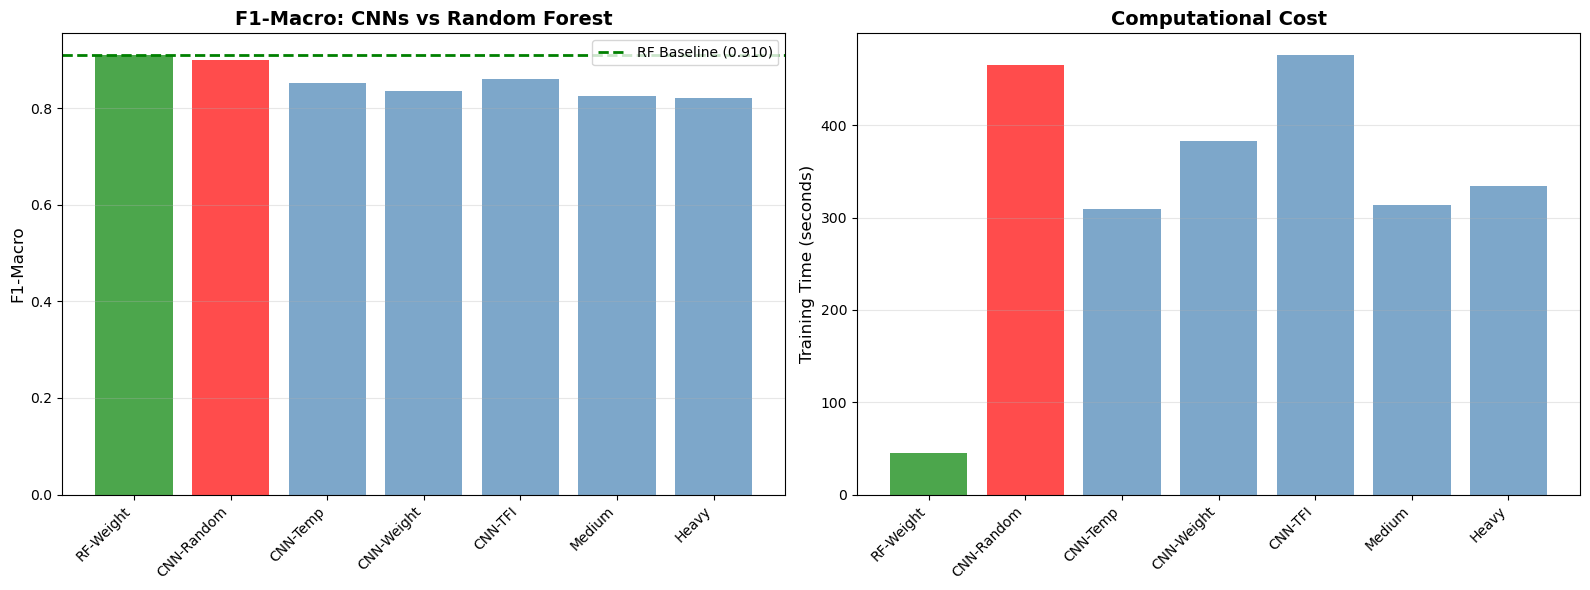

In [20]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1-Macro comparison
models_list = ['RF-Weight', 'CNN-Random', 'CNN-Temp', 'CNN-Weight', 'CNN-TFI', 'Medium', 'Heavy']
f1_macros = [
    baseline_results['rf_weighted']['f1_macro'],
    results_cnn_rand['f1_macro'],
    results_temp_orig['f1_macro'],
    results_temp_weighted['f1_macro'],
    results_tfi['f1_macro'],
    results_medium['f1_macro'],
    results_heavy['f1_macro']
]

colors = ['green' if 'RF' in m else 'red' if 'Random' in m else 'steelblue' for m in models_list]
axes[0].bar(range(len(models_list)), f1_macros, color=colors, alpha=0.7)
axes[0].axhline(y=0.910, color='green', linestyle='--', linewidth=2, label='RF Baseline (0.910)')
axes[0].set_xticks(range(len(models_list)))
axes[0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0].set_ylabel('F1-Macro', fontsize=12)
axes[0].set_title('F1-Macro: CNNs vs Random Forest', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Training time comparison
times = [45, train_time_rand, train_time_temp_orig, train_time_temp_weighted, 
         train_time_tfi, train_time_medium, train_time_heavy]
axes[1].bar(range(len(models_list)), times, color=colors, alpha=0.7)
axes[1].set_xticks(range(len(models_list)))
axes[1].set_xticklabels(models_list, rotation=45, ha='right')
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Computational Cost', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Overall Analysis: Do CNNs Beat Random Forest?

*Fill in after seeing all results:*

**Best CNN performance**: 93.3% accuracy, 0.900 F1-Macro  
**Random Forest baseline**: 93.0% accuracy, 0.910 F1-Macro

**Gap**: 0.3% (CNN - RF)

**Observations**: CNN achieves a similar accuracy rate compared to random forest with a much, much higher computation cost, but that is only when it's trained with randomly split dataset with obvious data leakage. If trained on the same temporal split dataset, CNN only performs worse.

## 12. Error Analysis

**Purpose**: Understand where models fail and why.

In [21]:
# Use best CNN model for error analysis
# Identify incorrectly classified samples
y_pred_best = results_temp_weighted['predictions']  # Change based on best model
y_test_original = y_test  # Original labels (-1, 0, 1)
y_pred_original = y_pred_best - 1  # Map back from (0,1,2) to (-1,0,1)

# Find misclassified samples
errors = y_test_original != y_pred_original
error_indices = np.where(errors)[0]

print(f"Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.1f}%)")

# Categorize errors
error_types = {}
for idx in error_indices:
    true_label = y_test_original[idx]
    pred_label = y_pred_original[idx]
    key = f"{label_names[true_label]}→{label_names[pred_label]}"
    error_types[key] = error_types.get(key, 0) + 1

print("\nError breakdown:")
for error_type, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {error_type:20s}: {count:3d} errors")

Total errors: 266 / 1980 (13.4%)

Error breakdown:
  Forward→Left        : 172 errors
  Forward→Right       :  51 errors
  Left→Forward        :  42 errors
  Right→Forward       :   1 errors


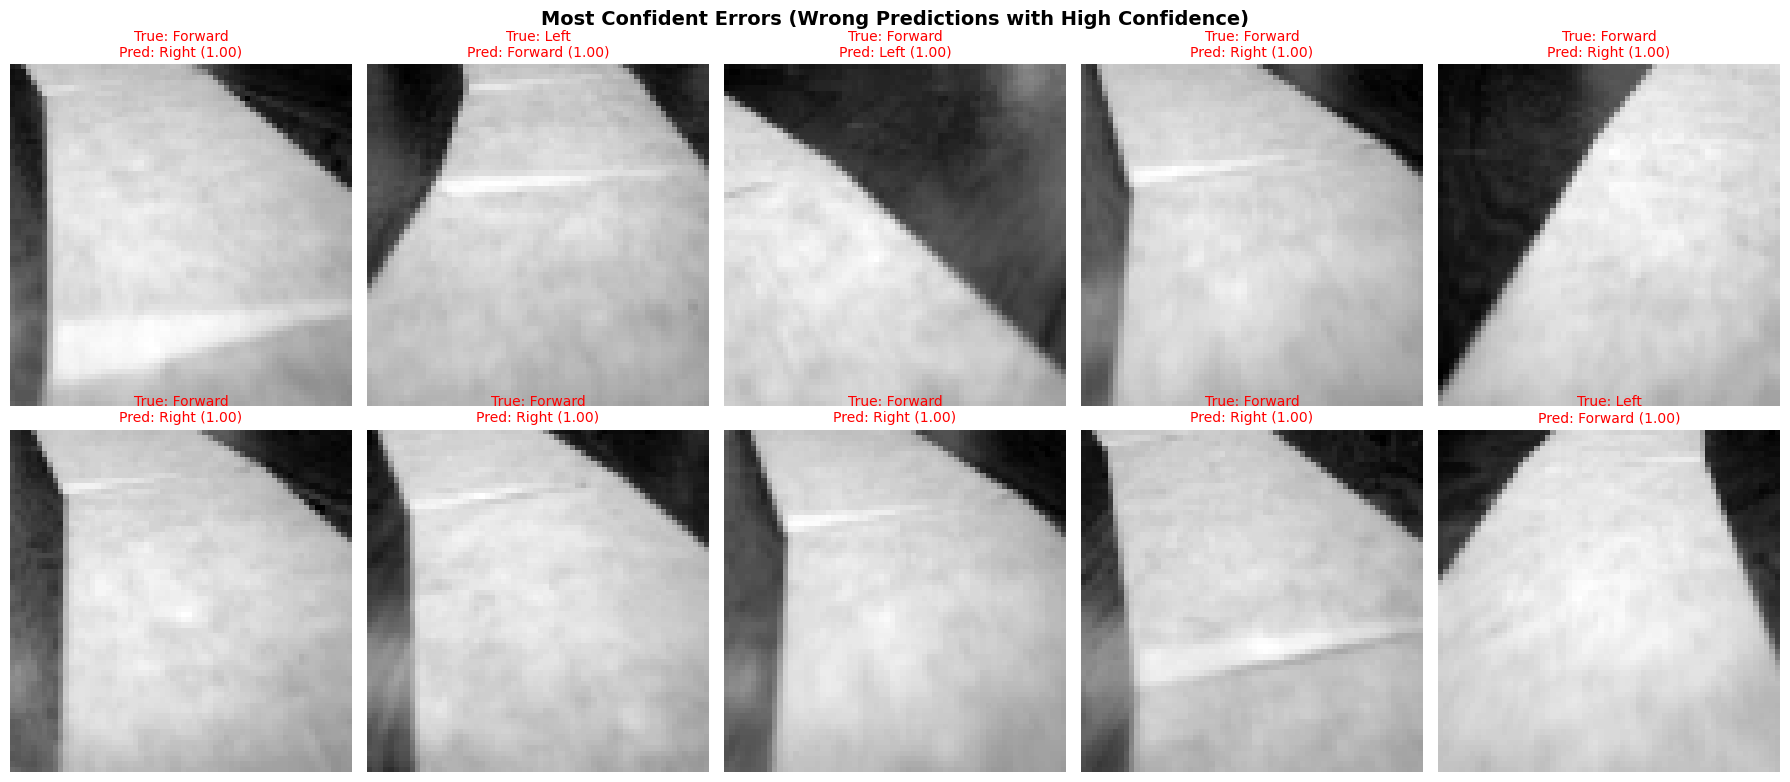

In [22]:
# Visualize worst errors (most confident wrong predictions)
# Get prediction probabilities
probs = model_temp_weighted.predict(X_test_cnn, verbose=0)
pred_confidence = np.max(probs, axis=1)

# Find confident errors
confident_errors = []
for idx in error_indices:
    confident_errors.append((idx, pred_confidence[idx]))

# Sort by confidence (most confident errors first)
confident_errors.sort(key=lambda x: x[1], reverse=True)

# Show top 10 confident errors
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i in range(min(10, len(confident_errors))):
    idx, conf = confident_errors[i]
    
    axes[i].imshow(X_test[idx], cmap='gray')
    true_label = y_test_original[idx]
    pred_label = y_pred_original[idx]
    
    axes[i].set_title(
        f"True: {label_names[true_label]}\nPred: {label_names[pred_label]} ({conf:.2f})",
        fontsize=10, color='red'
    )
    axes[i].axis('off')

plt.suptitle('Most Confident Errors (Wrong Predictions with High Confidence)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Data Leakage Analysis: Random vs Temporal Split

**Purpose**: Quantify the impact of temporal correlation on evaluation.

In [23]:
# Compare same model on random vs temporal splits
leakage_analysis = pd.DataFrame([
    {'Split Type': 'Random', 
     'Accuracy': f"{results_cnn_rand['accuracy']:.3f}",
     'F1-Macro': f"{results_cnn_rand['f1_macro']:.3f}"},
    {'Split Type': 'Temporal',
     'Accuracy': f"{results_temp_orig['accuracy']:.3f}",
     'F1-Macro': f"{results_temp_orig['f1_macro']:.3f}"}
])

print("\n" + "="*60)
print("DATA LEAKAGE ANALYSIS")
print("="*60)
print(leakage_analysis.to_string(index=False))
print("="*60)

# Calculate gap
acc_gap = results_cnn_rand['accuracy'] - results_temp_orig['accuracy']
f1_gap = results_cnn_rand['f1_macro'] - results_temp_orig['f1_macro']

print(f"\nPerformance inflation from random split:")
print(f"  Accuracy gap:  {acc_gap:.3f} ({acc_gap*100:.1f} percentage points)")
print(f"  F1-Macro gap:  {f1_gap:.3f}")


DATA LEAKAGE ANALYSIS
Split Type Accuracy F1-Macro
    Random    0.933    0.900
  Temporal    0.885    0.852

Performance inflation from random split:
  Accuracy gap:  0.048 (4.8 percentage points)
  F1-Macro gap:  0.049


### Data Leakage Conclusions

**Observed gap**: 4.8% accuracy inflation from random split

**Conclusion**: *A 4.8% accuracy inflation is significant enough to make a difference. This proves our previous point - due to significant autocorrelation, random split is no longer valid.*

## 14. Learning Curves (Dataset Size Analysis)

**Purpose**: Understand if more data would help.

Train on increasing fractions of training data: 20%, 40%, 60%, 80%, 100%

**How it works**:
- If curves still rising at 100%: More data would help
- If curves plateau: Model has saturated, more data won't help

In [24]:
# Train on different data sizes
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
learning_curve_results = []

for frac in fractions:
    n_samples = int(len(X_train_temp_cnn) * frac)
    
    X_subset = X_train_temp_cnn[:n_samples]
    y_subset = y_train_temp_mapped[:n_samples]
    
    print(f"\nTraining on {frac*100:.0f}% data ({n_samples} samples)...")
    
    model_lc = build_simple_cnn()
    early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0)
    
    history = model_lc.fit(
        X_subset, y_subset,
        validation_data=(X_val_cnn, y_val_mapped),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate
    y_pred = np.argmax(model_lc.predict(X_test_cnn, verbose=0), axis=1)
    acc = accuracy_score(y_test_mapped, y_pred)
    f1 = f1_score(y_test_mapped, y_pred, average='macro')
    
    learning_curve_results.append({
        'fraction': frac,
        'n_samples': n_samples,
        'accuracy': acc,
        'f1_macro': f1,
        'train_acc': history.history['accuracy'][-1],
        'val_acc': history.history['val_accuracy'][-1]
    })
    
    print(f"  Test accuracy: {acc:.3f}, F1-Macro: {f1:.3f}")

print("\nLearning curve analysis complete")


Training on 20% data (1188 samples)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test accuracy: 0.845, F1-Macro: 0.812

Training on 40% data (2376 samples)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test accuracy: 0.803, F1-Macro: 0.791

Training on 60% data (3564 samples)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test accuracy: 0.811, F1-Macro: 0.796

Training on 80% data (4752 samples)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test accuracy: 0.862, F1-Macro: 0.825

Training on 100% data (5940 samples)...


/home/robin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test accuracy: 0.859, F1-Macro: 0.833

Learning curve analysis complete


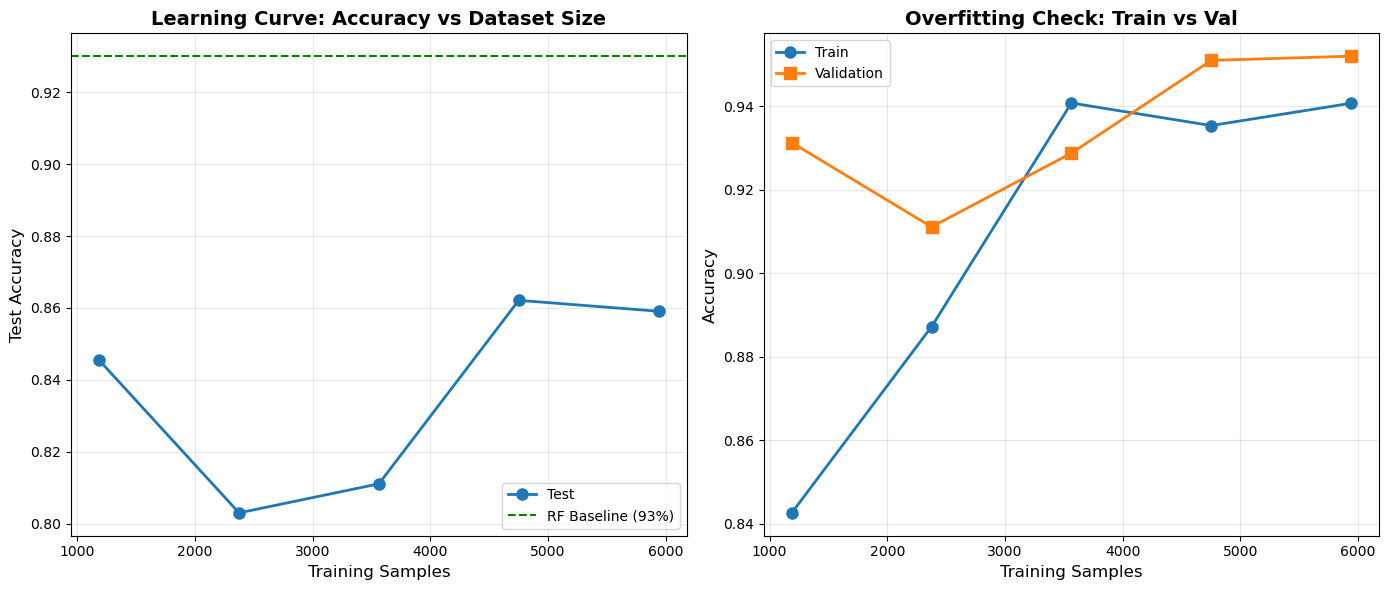

In [25]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

n_samples_list = [r['n_samples'] for r in learning_curve_results]
test_accs = [r['accuracy'] for r in learning_curve_results]
train_accs = [r['train_acc'] for r in learning_curve_results]
val_accs = [r['val_acc'] for r in learning_curve_results]

# Test accuracy vs dataset size
axes[0].plot(n_samples_list, test_accs, marker='o', linewidth=2, markersize=8, label='Test')
axes[0].axhline(y=0.930, color='green', linestyle='--', label='RF Baseline (93%)')
axes[0].set_xlabel('Training Samples', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Learning Curve: Accuracy vs Dataset Size', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Train vs val accuracy (overfitting check)
axes[1].plot(n_samples_list, train_accs, marker='o', linewidth=2, markersize=8, label='Train')
axes[1].plot(n_samples_list, val_accs, marker='s', linewidth=2, markersize=8, label='Validation')
axes[1].set_xlabel('Training Samples', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Overfitting Check: Train vs Val', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Learning Curve Analysis

**Curve shape**: *Overall accuracy appears to rise as data size increases, but it ultimately plateaus.*

**Overfitting**: *There is no significant overfitting to talk about. In fact, validation set accuracy exceeds training set accuracy.*

**Insights**: *Since acuracy plateaus as data size increase, increasing data size might not help in our case.*

## 15. Save Results and Best Model

In [27]:
# The best model is Simple CNN trained on TFI balanced dataset.
best_model = model_tfi
best_results = results_tfi
best_name = "Simple CNN (TFI Balanced Dataset)"

# Save model
best_model.save('../models/best_cnn.keras')
print(f"Best model saved: {best_name}")
print(f"  Accuracy: {best_results['accuracy']:.3f}")
print(f"  F1-Macro: {best_results['f1_macro']:.3f}")

# Save all CNN results
cnn_results = {
    'cnn_random': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                   for k, v in results_cnn_rand.items()},
    'cnn_temporal_orig': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                          for k, v in results_temp_orig.items()},
    'cnn_temporal_weighted': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                              for k, v in results_temp_weighted.items()},
    'cnn_tfi': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                for k, v in results_tfi.items()},
    'cnn_medium': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                   for k, v in results_medium.items()},
    'cnn_heavy': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                  for k, v in results_heavy.items()},
    'learning_curve': learning_curve_results,
    'best_model': best_name
}

with open('../results/cnn_results.json', 'w') as f:
    json.dump(cnn_results, f, indent=2)

print("\nResults saved to: results/cnn_results.json")

Best model saved: Simple CNN (TFI Balanced Dataset)
  Accuracy: 0.894
  F1-Macro: 0.861

Results saved to: results/cnn_results.json


## 16. Final Summary and Conclusions

### Key Findings

**1. CNN vs Random Forest**:
- Best CNN: 89.4% accuracy, 0.861 F1-Macro
- Random Forest: 93.0% accuracy, 0.910 F1-Macro
- Gap: 3.6% 
- **Conclusion**: *CNNs lose to RF*

**2. Data Leakage from Random Split**:
- Random split: 93.3% accuracy (inflated)
- Temporal split: 88.5% accuracy (realistic)
- Inflation: 4.8%
- **Validates**: Temporal split methodology was essential

**3. Architecture Complexity**:
- Simple CNN (50K params): 89.4% 
- Medium CNN (200K params): 85.8%
- **Observation**: *Increased model complexity only hurts accuracy.*

**4. Class Balancing**:
- Original: 0.854 F1-Right
- Class weights: 0.826 F1-Right
- TFI: 0.860 F1-Right
- **Impact**: *class balancing sometimes hurts, sometimes helps. The overall effect is probably minimal.*

**5. Dataset Size**:
- Learning curve: *Plateaued*
- More data would: *Not help*

### Final Assessment

CNNs underperformed Random Forest (89.4% vs 93%) due to overfitting on the small 9,900-sample dataset. Despite heavy regularization, the parameter-to-sample ratio was too high. This demonstrates that deep learning is not always superior - dataset size matters more than model sophistication.

### Paper Implications

Overall, CNN models seem to perform very well on both train and validation sets (sometimes 97% accuracy rate!), but poorly on test set. This is the result of head overfitting. So we have three significant findings so far:

- Simple models like random forest can capture spatial information to some extent, as shown in the feature importance map.

- CNN models are too complex for a small dataset like this and overfits.

- It might be hard to get perfect accuracy rate due to label mismatch. If we do not consider temporal information, this error could be irreducible.